<a href="https://colab.research.google.com/github/IzaakGagnon/SSC_GliderProject/blob/main/TEST_CODE/MORE_MORE_MODELS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
###############################################################

# Installs (only needed on first run)
!pip install ripser
!pip install persim
!pip install networkx
!pip install scikit-learn
!pip install matplotlib
!pip install tables



# Package imports (needed every run)
import numpy as np
import math
import pandas as pd
import random
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams
from scipy.spatial.distance import pdist, squareform
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting
import os # Required to use file paths
import shutil # Required to move temporary files around
import random # Used to create training/testing split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import KFold


# As needed
from google.colab import drive
drive.mount('/content/drive')


# Tell python which folder to look in. Change depending on the bin dimension
dim_bins = 100

relative_path = f"/dim_bins{dim_bins}/"

# Function to the h5 file at the chosen path
def read_h5(file_path):
    if file_path.endswith(".h5"):
      df = pd.read_hdf(file_path)
      print("File successfully read.\n")
      return df
    else:
      print("File is not an h5. Skipping...\n")

folder_path = f"/content/drive/MyDrive/dim_bins50"

file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
print(file_names)
def split_files(file_names, num_training):
    # Randomly select 'num_in_list1' files
    training_split = random.sample(file_names, num_training)
    # The remaining files
    testing_split = [f for f in file_names if f not in training_split]
    return training_split, testing_split
print(len(file_names))
testing_amount = 16
num_training = len(file_names) - testing_amount
print(num_training)  # 12 testing files, rest for training + eval
training_split, testing_split = split_files(file_names, num_training)

print("Training Split:", training_split)
print("Testing Split:", testing_split)

training_datasets = [pd.read_hdf(os.path.join(folder_path, f), key="data") for f in training_split]
testing_datasets = [pd.read_hdf(os.path.join(folder_path, f), key="data") for f in testing_split]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['component_19_binned_5641.h5', 'component_32_binned_7828.h5', 'component_12_binned_6936.h5', 'component_29_binned_7252.h5', 'component_20_binned_12556.h5', 'component_23_binned_6397.h5', 'component_28_binned_6517.h5', 'component_18_binned_5127.h5', 'component_30_binned_6746.h5', 'component_31_binned_4006.h5', 'component_27_binned_6032.h5', 'component_22_binned_6090.h5', 'component_26_binned_5265.h5', 'component_16_binned_7076.h5', 'component_25_binned_4878.h5', 'component_24_binned_7926.h5', 'component_6_binned_13296.h5', 'component_11_binned_6741.h5', 'component_9_binned_11350.h5', 'component_13_binned_8869.h5', 'component_1_binned_12968.h5', 'component_4_binned_5289.h5', 'component_21_binned_10418.h5', 'component_7_binned_8147.h5', 'component_3_binned_7318.h5', 'component_15_binned_10159.h5', 'component_5_binned_10452.h5', 'component_0_binned_8752.h5', 'co

Created 252 custom CV splits (5 train folds, 5 evaluation folds per split).


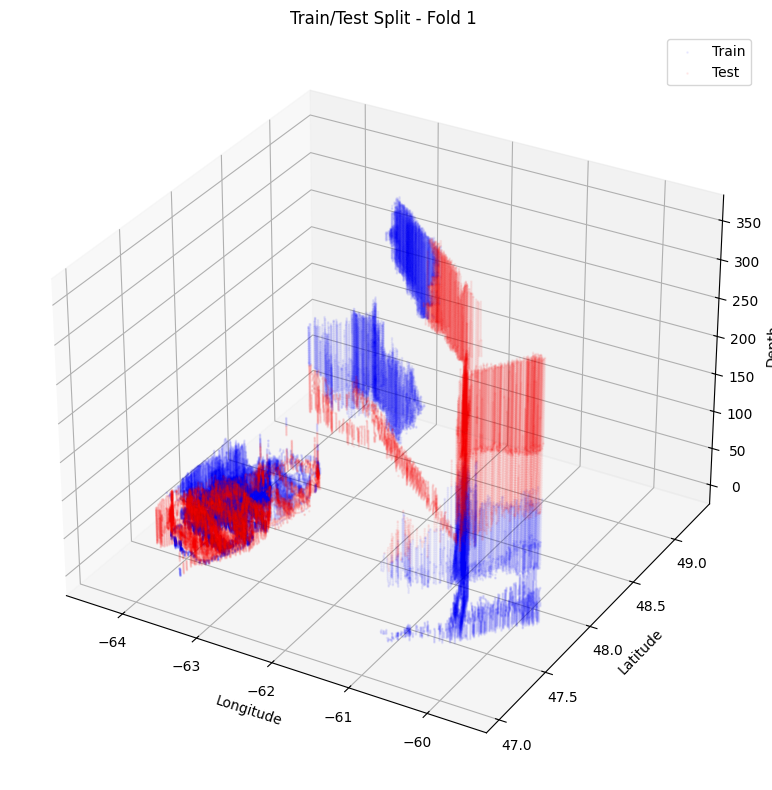

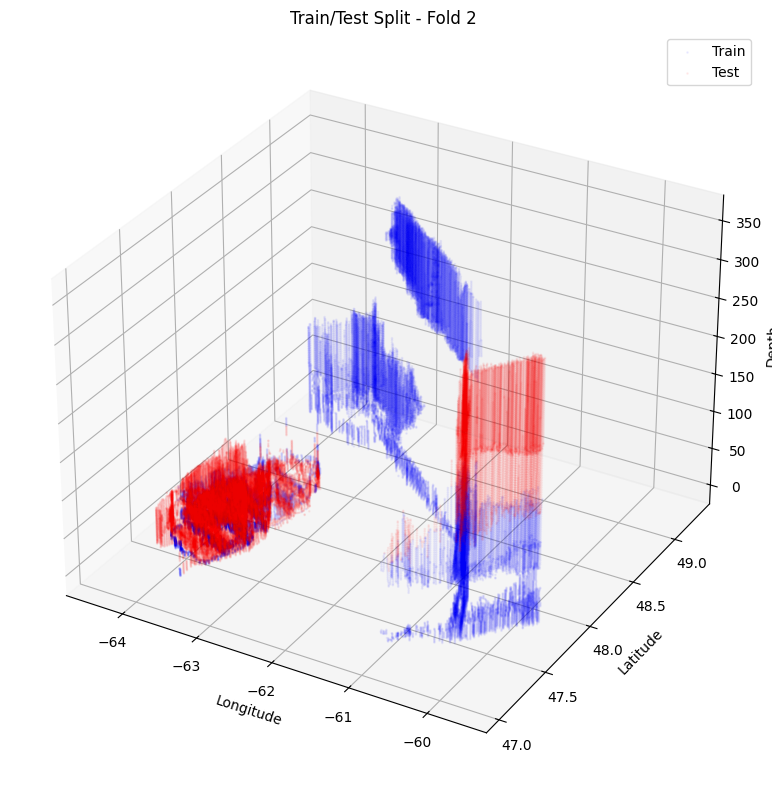

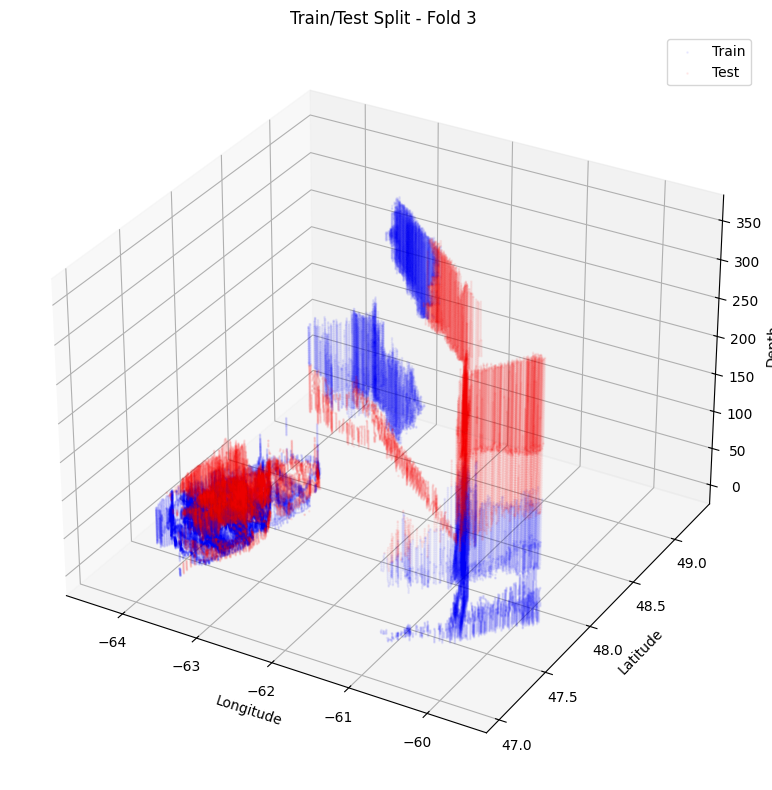

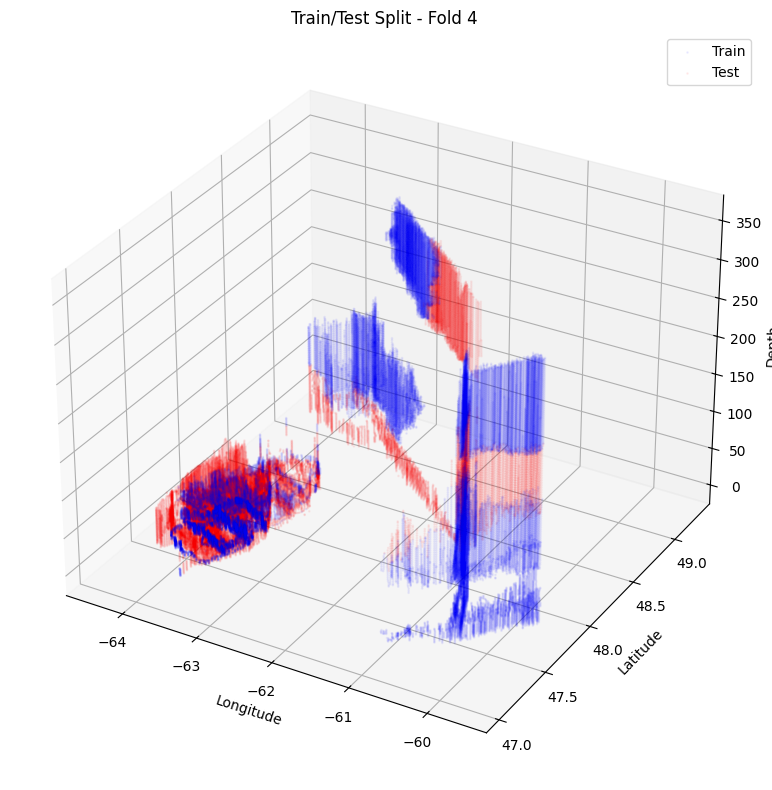

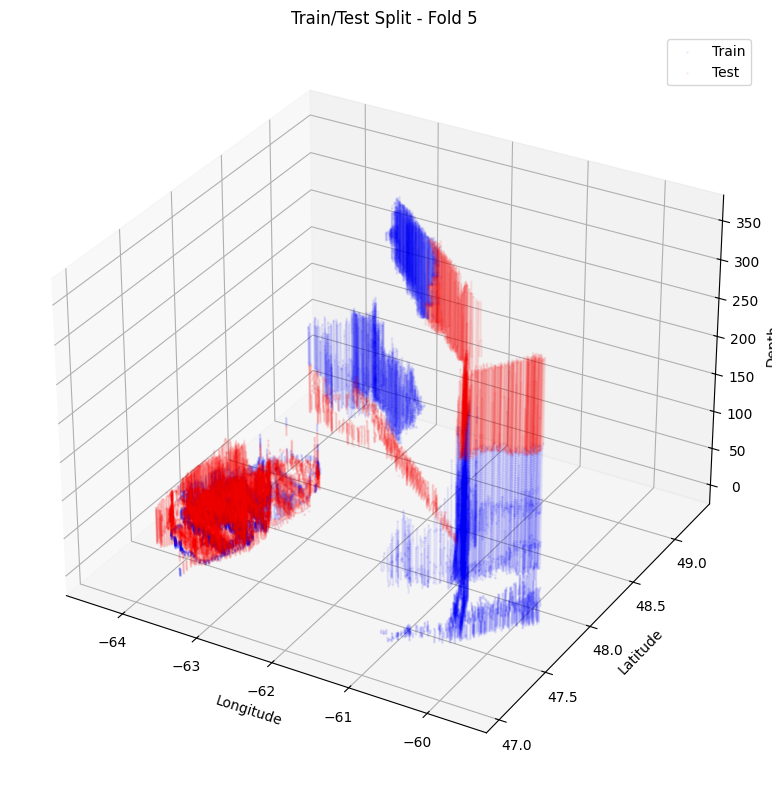

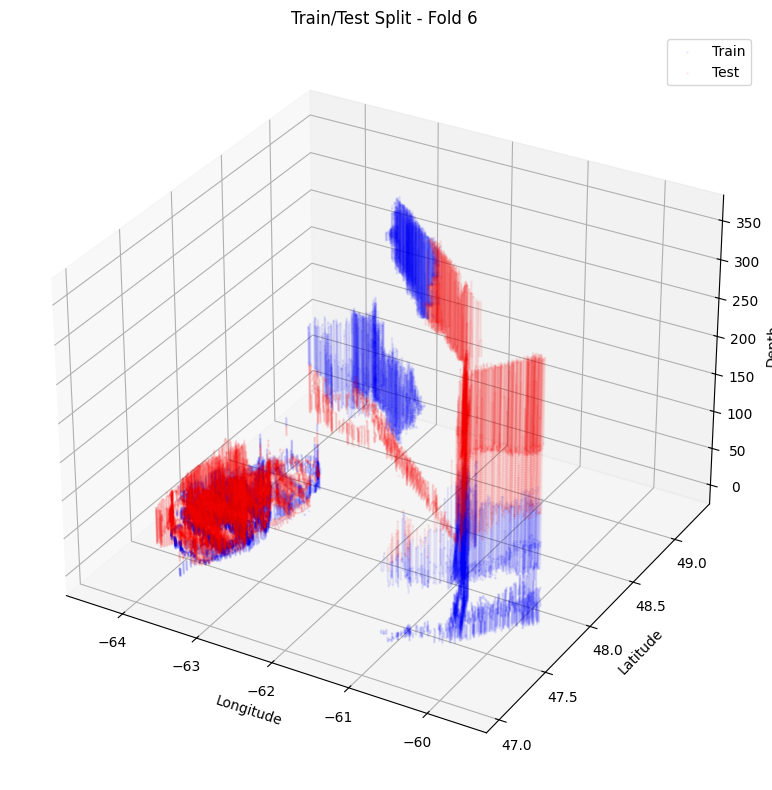

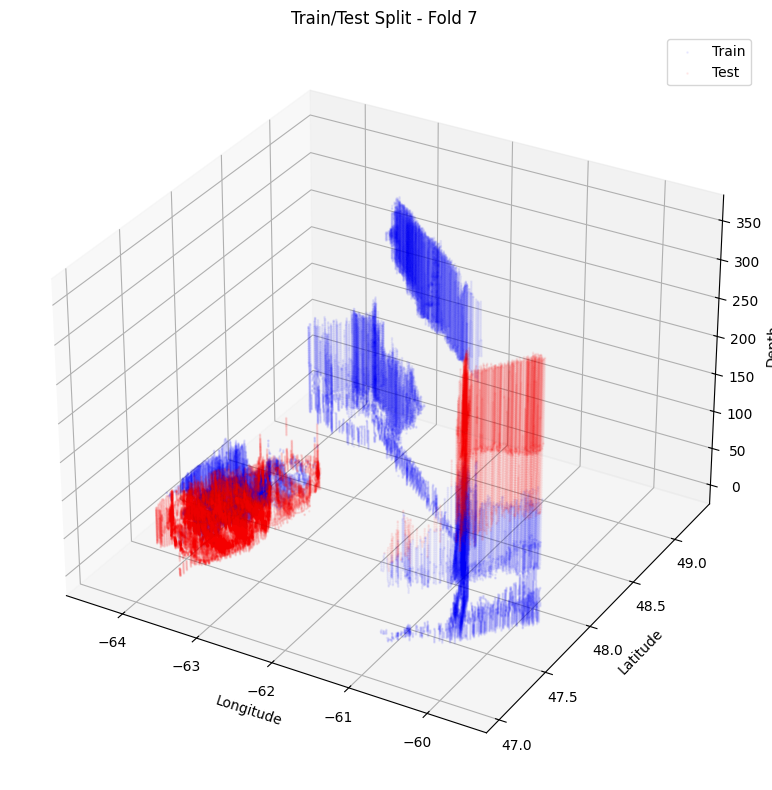

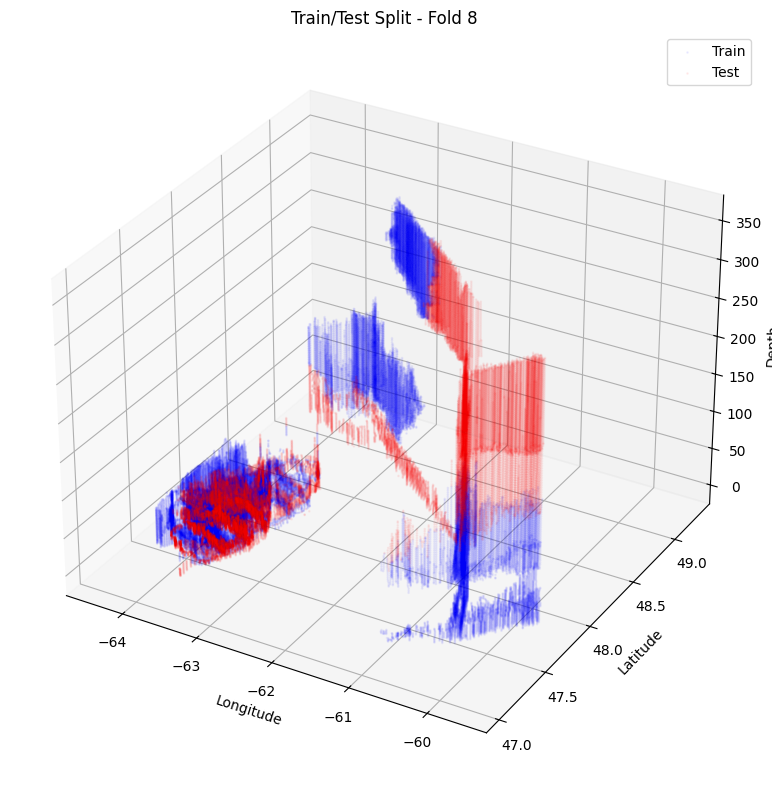

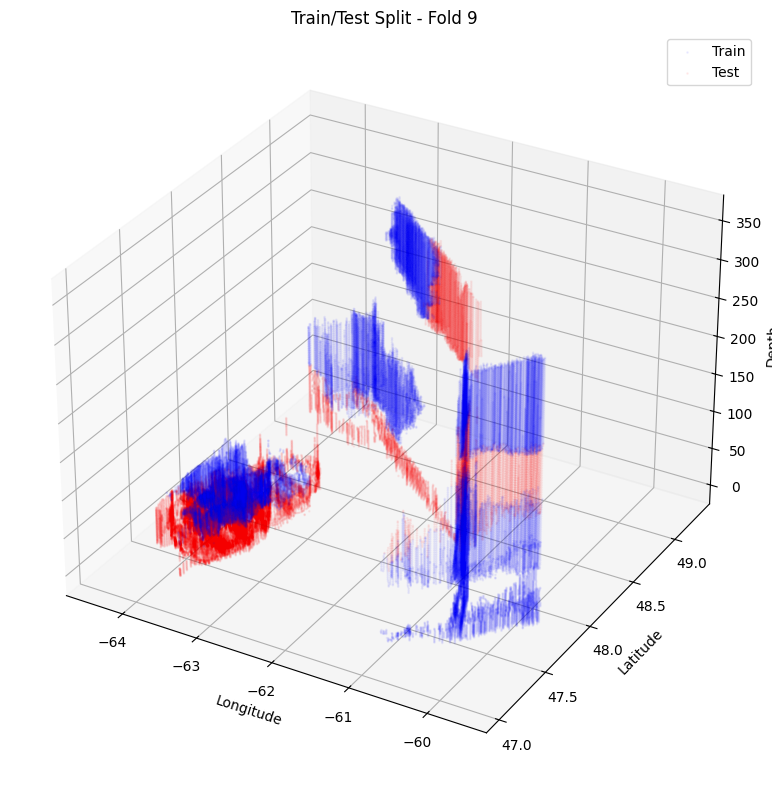

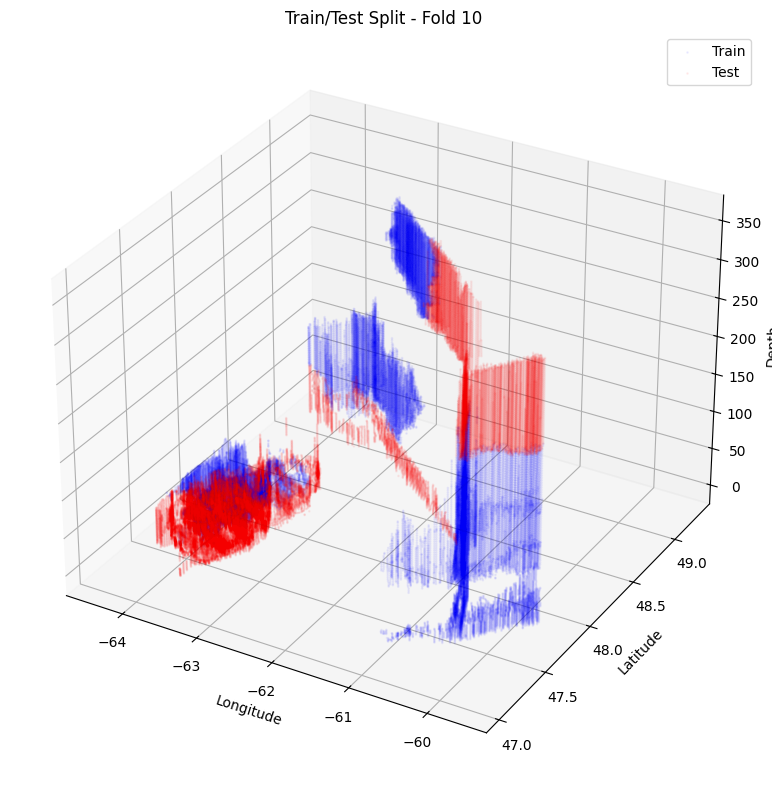

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from itertools import combinations

# Assume datasets is a list of preloaded DataFrames
n_datasets = len(training_datasets)
k = 10 # Total number of folds
train_folds_count = 5

# Step 1: Assign datasets to k folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)
dataset_indices = np.arange(n_datasets)

# Organize dataset indices into k folds
folds = [[] for _ in range(k)]
for fold_idx, (_, test_idx) in enumerate(kf.split(dataset_indices)):
    for i in test_idx:
        folds[fold_idx].append(i)

# Step 2: Generate all combinations of 4 folds for training
train_fold_combos = list(combinations(range(k), train_folds_count))
custom_folds = []

# Step 3: Build train/test sets for each combination
for train_combo in train_fold_combos:
    test_combo = [i for i in range(k) if i not in train_combo]

    train_indices = [idx for fold in train_combo for idx in folds[fold]]
    test_indices = [idx for fold in test_combo for idx in folds[fold]]

    train_df = pd.concat([training_datasets[i] for i in train_indices], ignore_index=True)
    test_df = pd.concat([training_datasets[i] for i in test_indices], ignore_index=True)

    custom_folds.append((train_df, test_df))

print(f"Created {len(custom_folds)} custom CV splits ({train_folds_count} train folds, {k - train_folds_count} evaluation folds per split).")

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Choose how many folds to visualize (or visualize all)
n_plot_folds = min(10, len(custom_folds))  # You can change this

for i in range(n_plot_folds):
    train_df, test_df = custom_folds[i]

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot training data (in blue)
    ax.scatter(
        train_df['longitude'], train_df['latitude'], train_df['depth'],
        c='blue', label='Train', alpha=0.05, s=1
    )

    # Plot testing data (in red)
    ax.scatter(
        test_df['longitude'], test_df['latitude'], test_df['depth'],
        c='red', label='Test', alpha=0.05, s=1
    )

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Depth')
    ax.set_title(f'Train/Test Split - Fold {i+1}')
    ax.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from itertools import product


# Cross validate to find optimal parameter for elastic net

target = 'oxygen'
exclude_cols = [target, 'voxel']

# Define your hyperparameter grid for ElasticNet (only tuning alpha)
param_grid = {
    'alpha': np.logspace(-3, 3, 10),  # penalty term
    'l1_ratio': np.linspace(0, 1, num=10)  # elasticnet mixing parameter, 0.5 means equal mix of Lasso and Ridge
}

# Convert to list of param combinations
param_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())

# To store average CV scores for each param combo
results = []

print(f"Total combinations of parameters to try: {len(param_combinations)}")
fold_count = 10
for combo in param_combinations:
    params = dict(zip(param_names, combo))
    mse_scores = []
    r2_scores = []

    for train_df, test_df in custom_folds[:fold_count]:
        X_train = train_df.drop(columns=exclude_cols)
        y_train = train_df[target]
        X_test = test_df.drop(columns=exclude_cols)
        y_test = test_df[target]

        model = ElasticNet(
            alpha=params['alpha'],
            l1_ratio=params['l1_ratio'],
            random_state=42
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mse_scores.append(mse)
        r2_scores.append(r2)
        print(f"R² across current fold: {r2} with length {len(custom_folds[:fold_count])}")

    avg_mse = np.mean(mse_scores)
    avg_r2 = np.mean(r2_scores)
    results.append((params, avg_mse, avg_r2))

    print(f"Params: {params}")
    print(f"→ Avg MSE: {avg_mse:.4f} | Avg R²: {avg_r2:.4f}\n")

# Find best param set
best_result = min(results, key=lambda x: x[1])  # smallest MSE
best_params, best_mse, best_r2 = best_result

print("\n===== Best Hyperparameters =====")
print(f"Best Params: {best_params}")
print(f"Avg MSE: {avg_mse:.4f}")
print(f"Avg R²: {avg_r2:.4f}")
print(f"Best RMSE: {np.sqrt(best_mse):.4f}")

# Model using optimal parameter

# Model evaluation on unseen testing data

train_df = pd.concat([training_datasets[i] for i in range(len(training_datasets))], ignore_index=True)
test_df = pd.concat([testing_datasets[i] for i in range(len(testing_datasets))], ignore_index=True)

target = 'oxygen'
exclude_cols = [target, 'voxel']

X_train = train_df.drop(columns=exclude_cols)
y_train = train_df[target]
X_test = test_df.drop(columns=exclude_cols)
y_test = test_df[target]

model = ElasticNet(
    alpha=best_params['alpha'],
    l1_ratio=best_params['l1_ratio'],
    random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse_scores.append(mse)
r2_scores.append(r2)
print(f"R² for Final Model: {r2}")
print(f"MSE for Final Model:{mse}")

Total combinations of parameters to try: 100


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.590e+07, tolerance: 4.142e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


R² across current fold: 0.743027925491333 with length 10


In [3]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from itertools import product
from joblib import Parallel, delayed

# Define target and columns to exclude
target = 'oxygen'
exclude_cols = [target, 'voxel']

# Hyperparameter grid for ElasticNet
param_grid = {
    'alpha': np.logspace(-3, 3, 10),       # penalty term
    'l1_ratio': np.linspace(0, 1, num=10)    # elasticnet mixing parameter
}

# Convert grid to list of combinations
param_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())

print(f"Total combinations of parameters to try: {len(param_combinations)}")
fold_count = 10  # Number of folds

# Define a function to evaluate one combination of hyperparameters
def evaluate_params(params):
    mse_scores = []
    r2_scores = []

    # Loop over each fold
    for train_df, test_df in custom_folds[:fold_count]:
        X_train = train_df.drop(columns=exclude_cols)
        y_train = train_df[target]
        X_test = test_df.drop(columns=exclude_cols)
        y_test = test_df[target]

        model = ElasticNet(alpha=params['alpha'],
                           l1_ratio=params['l1_ratio'],
                           random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mse_scores.append(mse)
        r2_scores.append(r2)
        print(f"Fold R²: {r2}")

    avg_mse = np.mean(mse_scores)
    avg_r2 = np.mean(r2_scores)
    print(f"Params: {params} → Avg MSE: {avg_mse:.4f} | Avg R²: {avg_r2:.4f}\n")
    return (params, avg_mse, avg_r2)

# Evaluate all hyperparameter combinations in parallel
results = Parallel(n_jobs=-1)(
    delayed(evaluate_params)(dict(zip(param_names, combo)))
    for combo in param_combinations
)

# Find best parameter set (using smallest MSE)
best_result = min(results, key=lambda x: x[1])
best_params, best_mse, best_r2 = best_result

print("\n===== Best Hyperparameters =====")
print(f"Best Params: {best_params}")
print(f"Avg MSE: {best_mse:.4f}")
print(f"Avg R²: {best_r2:.4f}")
print(f"Best RMSE: {np.sqrt(best_mse):.4f}")

# Train final model on the full training data and evaluate on unseen test data
train_df = pd.concat([training_datasets[i] for i in range(len(training_datasets))], ignore_index=True)
test_df = pd.concat([testing_datasets[i] for i in range(len(testing_datasets))], ignore_index=True)

X_train = train_df.drop(columns=exclude_cols)
y_train = train_df[target]
X_test = test_df.drop(columns=exclude_cols)
y_test = test_df[target]

final_model = ElasticNet(alpha=best_params['alpha'],
                         l1_ratio=best_params['l1_ratio'],
                         random_state=42)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, y_pred)
final_r2 = r2_score(y_test, y_pred)

print(f"R² for Final Model: {final_r2}")
print(f"MSE for Final Model: {final_mse}")


Total combinations of parameters to try: 100

===== Best Hyperparameters =====
Best Params: {'alpha': np.float64(2.154434690031882), 'l1_ratio': np.float64(0.8888888888888888)}
Avg MSE: 618.8709
Avg R²: 0.8997
Best RMSE: 24.8771
R² for Final Model: 0.8655803203582764
MSE for Final Model: 869.2391967773438


In [4]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.3/201.3 MB 5.3 MB/s eta 0:00:00


In [6]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from itertools import product
from joblib import Parallel, delayed

target = 'oxygen'
exclude_cols = [target, 'voxel']

# Define your hyperparameter grid
param_grid = {
    'n_estimators': [100],
    'learning_rate': np.linspace(0.01, 0.5, 100),
    'max_depth': [6],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

# Convert grid to a list of parameter combinations
param_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())

print(f"Total combinations of parameters to try: {len(param_combinations)}")
fold_count = 10  # number of folds to use from custom_folds

def evaluate_params(params, folds):
    mse_scores = []
    r2_scores = []
    for train_df, test_df in folds:
        X_train = train_df.drop(columns=exclude_cols)
        y_train = train_df[target]
        X_test = test_df.drop(columns=exclude_cols)
        y_test = test_df[target]

        model = xgb.XGBRegressor(
            **params,
            random_state=42,
            verbosity=0
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse_scores.append(mean_squared_error(y_test, y_pred))
        r2_scores.append(r2_score(y_test, y_pred))
        print(f"R² for current fold: {r2_scores[-1]} with {len(folds)} folds")

    avg_mse = np.mean(mse_scores)
    avg_r2 = np.mean(r2_scores)
    print(f"Evaluated params {params}: Avg MSE = {avg_mse:.4f} | Avg R² = {avg_r2:.4f}")
    return (params, avg_mse, avg_r2)

# Parallelize evaluation over all parameter combinations
results = Parallel(n_jobs=-1)(
    delayed(evaluate_params)(
        dict(zip(param_names, combo)),
        custom_folds[:fold_count]
    )
    for combo in param_combinations
)

# Find best param set (using smallest average MSE)
best_result = min(results, key=lambda x: x[1])
best_params, best_mse, best_r2 = best_result

print("\n===== Best Hyperparameters =====")
print(f"Best Params: {best_params}")
print(f"Avg MSE: {best_mse:.4f}")
print(f"Avg R²: {best_r2:.4f}")
print(f"Best RMSE: {np.sqrt(best_mse):.4f}")

# Now, you can proceed to train your final model using best_params.


# Train final model on the full training data and evaluate on unseen test data
train_df = pd.concat([training_datasets[i] for i in range(len(training_datasets))], ignore_index=True)
test_df = pd.concat([testing_datasets[i] for i in range(len(testing_datasets))], ignore_index=True)

X_train = train_df.drop(columns=exclude_cols)
y_train = train_df[target]
X_test = test_df.drop(columns=exclude_cols)
y_test = test_df[target]

final_model = xgb.XGBRegressor(
    **best_params,
    random_state=42,
    verbosity=0
)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, y_pred)
final_r2 = r2_score(y_test, y_pred)

print(f"R² for Final Model: {final_r2}")
print(f"MSE for Final Model: {final_mse}")

Total combinations of parameters to try: 100

===== Best Hyperparameters =====
Best Params: {'n_estimators': 100, 'learning_rate': np.float64(0.207979797979798), 'max_depth': 6, 'subsample': 0.8, 'colsample_bytree': 0.8}
Avg MSE: 603.7434
Avg R²: 0.9036
Best RMSE: 24.5712
R² for Final Model: 0.9690819978713989
MSE for Final Model: 199.93466186523438


In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from itertools import product
from joblib import Parallel, delayed

# Define target and columns to exclude
target = 'oxygen'
exclude_cols = [target, 'voxel']

# Hyperparameter grid for RandomForestRegressor
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 15, 20, 25],
    'min_samples_split': [2, 4, 6, 8, 10]
}

# Create a list of all parameter combinations
param_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())

print(f"Total parameter combinations: {len(param_combinations)}")
fold_count = 10  # Number of CV folds to use (from your custom_folds)

def evaluate_params(params, folds):
    mse_scores = []
    r2_scores = []
    for train_df, test_df in folds:
        # Prepare training and testing data
        X_train = train_df.drop(columns=exclude_cols)
        y_train = train_df[target]
        X_test = test_df.drop(columns=exclude_cols)
        y_test = test_df[target]

        # Initialize and train the model with current hyperparameters
        model = RandomForestRegressor(**params, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mse_scores.append(mse)
        r2_scores.append(r2)
        print(f"Fold R²: {r2}")

    avg_mse = np.mean(mse_scores)
    avg_r2 = np.mean(r2_scores)
    print(f"Evaluated params {params}: Avg MSE = {avg_mse:.4f} | Avg R² = {avg_r2:.4f}")
    return (params, avg_mse, avg_r2)

# Evaluate all parameter combinations in parallel
results = Parallel(n_jobs=-1)(
    delayed(evaluate_params)(
        dict(zip(param_names, combo)),
        custom_folds[:fold_count]
    )
    for combo in param_combinations
)

# Select the best parameter combination based on the smallest average MSE
best_result = min(results, key=lambda x: x[1])
best_params, best_mse, best_r2 = best_result

print("\n===== Best Hyperparameters =====")
print(f"Best Params: {best_params}")
print(f"Avg MSE: {best_mse:.4f}")
print(f"Avg R²: {best_r2:.4f}")
print(f"Best RMSE: {np.sqrt(best_mse):.4f}")

# Now, you can train your final RandomForest model using best_params.


Total parameter combinations: 50


In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from itertools import product
from joblib import Parallel, delayed

# Define target and columns to exclude
target = 'oxygen'
exclude_cols = [target, 'voxel']

# Hyperparameter grid for ElasticNet
param_grid = {
    'alpha': np.logspace(-3, 3, 10),  # penalty term
    'l1_ratio': np.linspace(0, 1, num=10)  # mix parameter (0.5 = equal mix)
}

# Create list of all parameter combinations
param_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())

print(f"Total combinations of parameters to try: {len(param_combinations)}")
fold_count = 10  # number of folds to use from custom_folds

# Define a function to evaluate one parameter combo on the CV folds
def evaluate_params(params, folds):
    mse_scores = []
    r2_scores = []
    for train_df, test_df in folds:
        # Prepare training and testing data
        X_train = train_df.drop(columns=exclude_cols)
        y_train = train_df[target]
        X_test = test_df.drop(columns=exclude_cols)
        y_test = test_df[target]

        # Initialize and train the model
        model = ElasticNet(alpha=params['alpha'],
                           l1_ratio=params['l1_ratio'],
                           random_state=42069)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Compute performance metrics
        mse_scores.append(mean_squared_error(y_test, y_pred))
        r2_scores.append(r2_score(y_test, y_pred))

    avg_mse = np.mean(mse_scores)
    avg_r2 = np.mean(r2_scores)
    print(f"Evaluated params {params}: Avg MSE = {avg_mse:.4f} | Avg R² = {avg_r2:.4f}")
    return (params, avg_mse, avg_r2)

# Use Parallel to evaluate all parameter combinations concurrently.
results = Parallel(n_jobs=-1)(
    delayed(evaluate_params)(
        dict(zip(param_names, combo)),
        custom_folds[:fold_count]
    )
    for combo in param_combinations
)

# Find best parameter set (using smallest average MSE)
best_result = min(results, key=lambda x: x[1])
best_params, best_mse, best_r2 = best_result

print("\n===== Best Hyperparameters =====")
print(f"Best Params: {best_params}")
print(f"Avg MSE: {best_mse:.4f}")
print(f"Avg R²: {best_r2:.4f}")
print(f"Best RMSE: {np.sqrt(best_mse):.4f}")

# Now, you can train your final model using best_params.


In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from itertools import product
from joblib import Parallel, delayed

# Define target and columns to exclude
target = 'oxygen'
exclude_cols = [target, 'voxel']

# Hyperparameter grid for ElasticNet
param_grid = {
    'alpha': np.logspace(-3, 3, 10),  # penalty term
    'l1_ratio': np.linspace(0, 1, num=10)  # mix parameter (0.5 = equal mix)
}

# Create list of all parameter combinations
param_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())

print(f"Total combinations of parameters to try: {len(param_combinations)}")
fold_count = 10  # number of folds to use from custom_folds

# Define a function to evaluate one parameter combo on the CV folds
def evaluate_params(params, folds):
    mse_scores = []
    r2_scores = []
    for train_df, test_df in folds:
        # Prepare training and testing data
        X_train = train_df.drop(columns=exclude_cols)
        y_train = train_df[target]
        X_test = test_df.drop(columns=exclude_cols)
        y_test = test_df[target]

        # Initialize and train the model
        model = ElasticNet(alpha=params['alpha'],
                           l1_ratio=params['l1_ratio'],
                           random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Compute performance metrics
        mse_scores.append(mean_squared_error(y_test, y_pred))
        r2_scores.append(r2_score(y_test, y_pred))

    avg_mse = np.mean(mse_scores)
    avg_r2 = np.mean(r2_scores)
    print(f"Evaluated params {params}: Avg MSE = {avg_mse:.4f} | Avg R² = {avg_r2:.4f}")
    return (params, avg_mse, avg_r2)

# Use Parallel to evaluate all parameter combinations concurrently.
results = Parallel(n_jobs=-1)(
    delayed(evaluate_params)(
        dict(zip(param_names, combo)),
        custom_folds[:fold_count]
    )
    for combo in param_combinations
)

# Find best parameter set (using smallest average MSE)
best_result = min(results, key=lambda x: x[1])
best_params, best_mse, best_r2 = best_result

print("\n===== Best Hyperparameters =====")
print(f"Best Params: {best_params}")
print(f"Avg MSE: {best_mse:.4f}")
print(f"Avg R²: {best_r2:.4f}")
print(f"Best RMSE: {np.sqrt(best_mse):.4f}")

# Now, you can train your final model using best_params.


A Custom CV Fold Generator

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Grab last fold's residuals (or use any index: e.g., 0 for first)
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]
X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]

# Train a new RF model (or reuse the one from the CV loop)
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# Compute residuals
residuals = y_test - y_pred

# 1. Residuals vs. Predictions
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values (Random Forest)")
plt.grid(True)
plt.show()

# 2. Histogram of residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Histogram of Residuals (Random Forest)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# 3. Optional: QQ Plot
plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals (Random Forest)")
plt.grid(True)
plt.show()


NameError: name 'train_df' is not defined

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Replace with the actual column name of your target
target_col = 'oxygen'  # example

mse_rf_scores = []
r2_rf_scores = []

for i, (train_df, test_df) in enumerate(custom_folds):
    X_train = train_df.drop(columns=[target_col,'voxel'])
    y_train = train_df[target_col]
    X_test = test_df.drop(columns=[target_col,'voxel'])
    y_test = test_df[target_col]

    # Define and train Random Forest model
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)

    # Predictions
    y_pred = rf_model.predict(X_test)

    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mse_rf_scores.append(mse)
    r2_rf_scores.append(r2)

    print(f"[RF] Fold {i+1:03d} | MSE: {mse:.4f} | R²: {r2:.4f}")

# Final summary
print("\n===== Random Forest CV Results =====")
print(f"Average MSE: {np.mean(mse_rf_scores):.4f} ± {1.96*np.std(mse_rf_scores):.4f}")
print(f"Average R²: {np.mean(r2_rf_scores):.4f} ± {1.96*np.std(r2_rf_scores):.4f}")


In [ ]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from itertools import product

target = 'oxygen'
exclude_cols = [target, 'voxel']

# Define your hyperparameter grid
param_grid = {
    'n_estimators': [100],
    'learning_rate': np.linspace(0.01, 0.1, 10),
    #'learning_rate': [0.06],
    'max_depth': [8],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

# Convert to list of param combinations
param_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())

# To store average CV scores for each param combo
results = []

print(f"Total combinations of parameters to try: {len(param_combinations)}")
fold_count = 10
for combo in param_combinations:
    params = dict(zip(param_names, combo))
    mse_scores = []
    r2_scores = []

    for train_df, test_df in custom_folds[:fold_count]:
        X_train = train_df.drop(columns=exclude_cols)
        y_train = train_df[target]
        X_test = test_df.drop(columns=exclude_cols)
        y_test = test_df[target]

        model = xgb.XGBRegressor(
            **params,
            random_state=42,
            verbosity=0
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mse_scores.append(mse)
        r2_scores.append(r2)
        print(f"R² across current fold: {r2} with length {len(custom_folds[:fold_count])}")

    avg_mse = np.mean(mse_scores)
    avg_r2 = np.mean(r2_scores)
    results.append((params, avg_mse, avg_r2))

    print(f"Params: {params}")
    print(f"→ Avg MSE: {avg_mse:.4f} | Avg R²: {avg_r2:.4f}\n")

# Find best param set
best_result = min(results, key=lambda x: x[1])  # smallest MSE
best_params, best_mse, best_r2 = best_result

print("\n===== Best Hyperparameters =====")
print(f"Best Params: {best_params}")
print(f"Avg MSE: {best_mse:.4f}")
print(f"Avg R²: {best_r2:.4f}")
print(f"Best RMSE: {np.sqrt(best_mse):.4f}")


In [ ]:
results_df = pd.DataFrame([
    {
        **params,
        'avg_mse': avg_mse,
        'avg_r2': avg_r2,
        'avg_rmse': np.sqrt(avg_mse)
    }
    for params, avg_mse, avg_r2 in results
])
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=results_df,
    x='learning_rate',
    y='avg_rmse',
    marker='o',
    palette='tab10'
)

plt.title("RMSE vs Max Depth (Colored by Learning Rate)")
plt.xlabel("Max Depth")
plt.ylabel("Average RMSE")
plt.grid(True)
plt.legend(title='Learning Rate')
plt.tight_layout()
plt.show()
